In [1]:
from pint import UnitRegistry

In [22]:
ureg = UnitRegistry(system="SI")

In [23]:
a = 1.0 * ureg.hartree

In [24]:
a.to(ureg.calorie)

1.0420039967034343e-18 <Unit('calorie')>

In [25]:
u = ureg.eV / ureg.molecule

In [26]:
u

<Unit('electron_volt / particle')>

In [27]:
a = 1 * u
a.to(ureg.kcalorie / ureg.mol)

23.06054783061903 <Unit('kilocalorie / mole')>

In [28]:
a.to_base_units()

96485.33212331001 <Unit('kilogram * meter ** 2 / mole / second ** 2')>

In [32]:
a.units

<Unit('electron_volt / particle')>

In [86]:
from rdkit import Chem
from rdkit.Chem import Draw

mol = Chem.RWMol(Chem.MolFromXYZFile("../test/test.xyz"))
mol

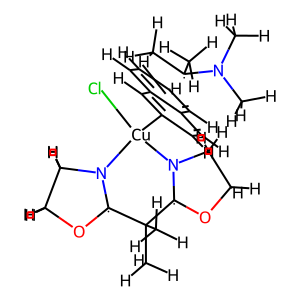

In [87]:
mol2 = Chem.MolFromMolFile(
    "../test/test.sdf",
    removeHs=False,
)
Draw.MolToImage(mol2)

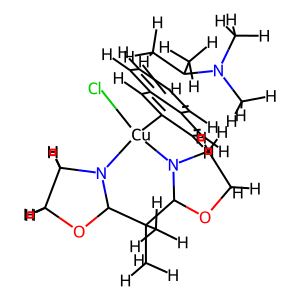

In [88]:
for bond in mol2.GetBonds():
    mol.AddBond(bond.GetBeginAtomIdx(), bond.GetEndAtomIdx(), bond.GetBondType())
Draw.MolToImage(mol)

In [89]:
pt = Chem.GetPeriodicTable()
for atom in mol.GetAtoms():
    if pt.GetDefaultValence(atom.GetAtomicNum()) > atom.GetExplicitValence():
        print(
            atom.GetAtomicNum(),
            pt.GetDefaultValence(atom.GetAtomicNum()),
            atom.GetExplicitValence(),
            atom.GetFormalCharge(),
            atom.GetSymbol(),
        )
        atom.SetNumRadicalElectrons(1)

6 4 3 0 C
6 4 3 0 C
6 4 3 0 C


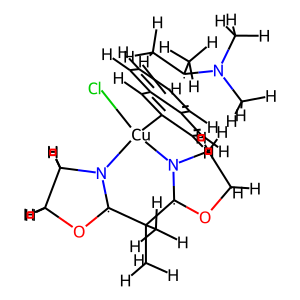

In [90]:
Draw.MolToImage(mol)

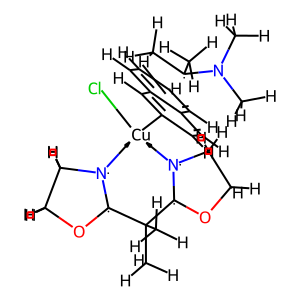

In [91]:
from rdkit.Chem import AllChem

for start, end in mol.GetSubstructMatches(Chem.MolFromSmarts("[N+0]-[Cu]")):
    mol.RemoveBond(start, end)
    mol.AddBond(start, end, Chem.BondType.DATIVE)
    mol.GetAtomWithIdx(start).SetNumRadicalElectrons(1)
Draw.MolToImage(mol)

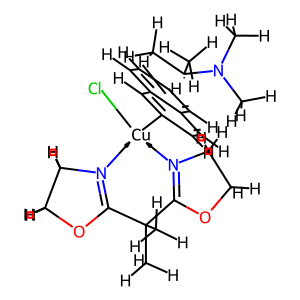

In [92]:
for bond in mol.GetBonds():
    if (
        bond.GetBeginAtom().GetNumRadicalElectrons() == 1
        and bond.GetEndAtom().GetNumRadicalElectrons() == 1
    ):
        bond.SetBondType(Chem.rdchem.BondType.DOUBLE)
        bond.GetBeginAtom().SetNumRadicalElectrons(0)
        bond.GetEndAtom().SetNumRadicalElectrons(0)
Draw.MolToImage(mol)

In [93]:
Chem.SanitizeMol(mol)

rdkit.Chem.rdmolops.SanitizeFlags.SANITIZE_NONE

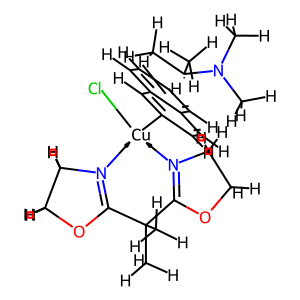

In [95]:
Draw.MolToImage(mol)

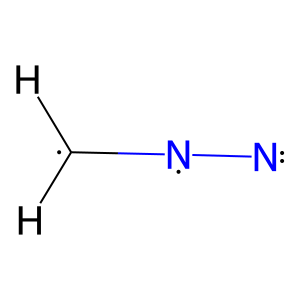

In [150]:
"""
Author: TMJ
Date: 2023-12-31 16:40:56
LastEditors: TMJ
LastEditTime: 2024-01-07 16:55:56
Description: 请填写简介
"""
from openbabel import pybel
from rdkit.Chem import AllChem

test_mol = Chem.MolFromSmiles("[N]#[N+][CH2-]")
test_mol = Chem.AddHs(test_mol)
AllChem.EmbedMolecule(test_mol)

omol = pybel.readstring("xyz", Chem.MolToXYZBlock(test_mol))
test_mol = Chem.MolFromMolBlock(omol.write("sdf"), removeHs=False)
Draw.MolToImage(test_mol)

In [133]:
NONMETAL = (
    "H",
    "He",
    "B",
    "C",
    "N",
    "O",
    "F",
    "Ne",
    "Si",
    "P",
    "S",
    "Cl",
    "Ar",
    "Br",
    "Kr",
    "I",
)
METAL = (
    element
    for element in [
        pt.GetElementSymbol(i)
        for i in range(1, 119)
        if pt.GetElementSymbol(i) not in NONMETAL
    ]
)
HETEROATOM = ("N", "O", "P", "S", "Cl", "I")


def xyz_to_mol(xyz_block: str, charge: int = 0, spin: int = 0):
    if abs(charge) > 2:
        raise ValueError("Charge must be between -2 and 2")
    if spin > 2 or spin < 0:
        raise ValueError("Spin must be between 0 and 2")
    from openbabel import pybel
    from rdkit import Chem
    from rdkit.Geometry import Point3D

    # Step 1: use openbabel to initialize molecule without charge and spin.
    # OpenBabel can use XYZ file to recover a molecule with proper bonds. 
    # If the molecule is a neutral molecule, the recovery will almostly always be true (dipole except).
    # Howerver, the lack is that OpenBabel does not consider the charge and spin information.
    # Therfore, the steps following will try to fix the charge and spin information.
    omol = pybel.readstring("xyz", xyz_block)
    refer_mol = Chem.RWMol(Chem.MolFromMolBlock(omol.write("sdf"), removeHs=False))

    # Step 2: process the molecule to allocate the charge.
    # The allocation will consume the number `charge_to_be_allocated`, and may reduce the spin in molecule.
    # Anyway, if charges have been all allocated, the spin remained will be used in the next step.
    charge_to_be_allocated = abs(charge)
    # Step 2.1: Whatever the charge is, there is possibility that the dipole exists. Find them first.
        # Hope not to have dipoles along with other charges.
    # Step 2.1.1(Type A): dipole like [CH2]=[O+]-[NH-].
    # OpenBabel will set the central atom to be neutral and the other two atoms neutral with spin 1.
    # Thus, find the combination of the two atoms with spin 1 and one heteroatom between them with spin 0. 
    # Negative charges are mutually resonant at any position of the atoms on either side. 
    # So it is straightforward to set one of the atoms as neutral and the other as charge -1.
    pass
    # Step 2.1.2(Type B): dipole like [CH]#[N+]-[O-]. This type only allow N (maybe P) to be the center.
    # OpenBabel will set the central atom N (maybe P) with spin 1, the neutral atom with spin 2, and the negative atom with spin 1.
    # Thus, find the combination of the three atoms follow rule above.
    # Negative charges are mutually resonant at any position of the atoms on either side. 
    # Nevertheless, I pact that atoms with spin 1 carry a formal charge -1.
    pass
    if charge > 0:
        # Step 2.2.1: if metal found, allocate all the positive charge to it.
        # Suppose only one metal atom.
        for atom in refer_mol.GetAtoms():
            if charge_to_be_allocated == 0:
                break
            if atom.GetSymbol() in METAL:
                atom.SetFormalCharge(atom.GetFormalCharge() + charge_to_be_allocated)
                charge_to_be_allocated -= charge_to_be_allocated
        # Step 2.2.2: if no metal found, try to find the heteroatom with positive charge.
        # Explaination:
        # In this case, OpenBabel will split the heteroatom and one substituent into a neutral heteroatom and a substituent with a free radical.
        # Therefore, try to find the heteroatom with a free radical and make sure the distance is less (or close to equal) than covalent bond length.
        # If found, allocate the positive charge to the heteroatom and build a single bond to connect the two atoms.
        for atom in refer_mol.GetAtoms():
            if charge_to_be_allocated == 0:
                break
            if atom.GetSymbol() in HETEROATOM:
                spin_atoms = [
                    atom
                    for atom in refer_mol.GetAtoms()
                    if atom.GetNumRadicalElectrons() == 1
                ]
                distances = [
                    Point3D.Distance(
                        refer_mol.GetConformer().GetAtomPosition(atom.GetIdx()),
                        refer_mol.GetConformer().GetAtomPosition(spin_atom.GetIdx()),
                    )
                    for spin_atom in spin_atoms
                ]
        # Step 2.2.3: if no heteroatom (with the neighboring free radical) found, allocate the positive charge to the carbon atom with free radical.
        # Explaination:
        # In this case, OpenBabel will consider the carbon atom lack of bonds, so it will set the spin to 1.
        # Thus, find the carbon atoms with free radical, set the charge to 1 and set the spin to 0.
        for atom in refer_mol.GetAtoms():
            if charge_to_be_allocated == 0:
                break
        # Step 2.2.4: if no above all found, allocate the positive charge to the hydrogen atom with free radical.
        for atom in refer_mol.GetAtoms():
            if charge_to_be_allocated == 0:
                break
    if charge < 0:
        pass
        